<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/autoencoder_%E8%BC%95%E6%B2%B9%E6%A1%88%E5%AD%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector,AveragePooling1D,Flatten,Reshape
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


# metric

In [0]:
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt
def metric(y_test,y_pred):
  res = pd.DataFrame(index=['score'])
  res['R2'] = r2_score(y_test,y_pred)
  res['RMSE'] = sqrt(mean_squared_error(y_test,y_pred))
  res['RMSE%'] = res['RMSE'] / np.mean(y_test)
  return res

# plot example

In [0]:
def plot_examples(stock_input, stock_decoded):
  n = 5;plt.figure(figsize=(20, 5))
  for i, idx in enumerate(list(np.arange(0, len(test), len(test)/n))):
    #真實
    ax = plt.subplot(2, n, i + 1)
    if i == 0:
      ax.set_ylabel("Input", fontweight=600)
    plt.imshow(np.array(stock_input.loc[idx]).reshape(1,stock_input.shape[1]))
    plt.title(int(idx))   
    #預測    
    ax = plt.subplot(2, n, i + 1 + n)
    if i == 0:
      ax.set_ylabel("Output", fontweight=600)
    plt.imshow(np.array(stock_decoded.loc[idx]).reshape(1,stock_decoded.shape[1]))
    plt.title(int(idx))    

# Load train

In [5]:
import pandas as pd
train = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/train_4521.csv',index_col=0)
train.head()

,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,100.5,119.2,146.5,31.978,0.272,0.132,0.059,5.293,2.570,2.819,0.494,10.395,8.070,6.411,2.917,9.138,9.649,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319
1,99.6,117.9,145.5,31.568,0.297,0.151,0.062,5.089,2.531,2.804,0.499,10.074,7.958,6.395,2.894,8.970,9.548,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303
2,100.0,118.8,145.6,31.344,0.262,0.126,0.061,5.107,2.571,2.771,0.492,10.069,7.913,6.378,2.890,9.006,9.591,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289
3,100.4,118.6,142.9,31.453,0.224,0.105,0.060,4.894,2.497,2.650,0.469,10.015,7.685,6.376,2.866,9.133,9.708,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281
4,100.4,118.1,142.2,32.190,0.243,0.117,0.061,4.946,2.503,2.695,0.477,10.053,7.765,6.394,2.877,9.101,9.676,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290


# Load test

In [6]:
test = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_170.csv',index_col=0)
test.head()

,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,98.6,119.2,146.1,40.133,1.142,0.616,0.217,3.745,2.577,4.028,0.557,7.669,5.9900,10.206,3.075,7.920,8.036,7.039,5.438,5.263,9.537,4.877,3.481,1.088,5.652,0.618,0.597
1,105.4,122.2,148.2,32.175,0.122,0.078,0.029,3.955,1.563,2.407,0.400,10.016,7.2633,6.573,2.809,9.544,9.815,5.135,5.482,6.793,10.850,4.308,3.963,1.069,6.025,0.585,0.484
2,105.8,122.7,149.2,31.428,0.098,0.064,0.020,3.920,1.447,2.296,0.396,10.236,7.3480,6.259,2.797,9.655,9.986,4.942,5.453,6.947,10.996,4.269,3.997,1.034,6.107,0.543,0.456
3,105.4,122.4,147.6,31.390,0.122,0.085,0.021,3.900,1.437,2.274,0.397,10.259,7.3560,6.234,2.820,9.670,10.146,4.928,5.476,6.953,11.026,4.264,3.982,1.013,6.054,0.545,0.449
4,105.4,122.6,148.2,32.418,0.072,0.049,0.015,3.873,1.369,2.206,0.489,10.213,7.3190,6.009,2.968,9.564,10.052,4.769,6.584,6.866,10.892,4.169,4.227,0.930,5.828,0.519,0.463


# features y_columns

In [7]:
features = train.columns.tolist()[:4]
y_columns = train.columns.tolist()[4:]
print(features)
print(y_columns)

['T10', 'T50', 'T90', 'N+A']
['C5NP', 'C5IP', 'C5N', 'C6NP', 'C6IP', 'C6N', 'C6A', 'C7NP', 'C7IP', 'C7N', 'C7A', 'C8NP', 'C8IP', 'C8N', 'C8A', 'C9NP', 'C9IP', 'C9N', 'C9A', 'C10NP', 'C10IP', 'C10N', 'C10A']


# standscaler X , Normalize y

In [0]:
from sklearn.preprocessing import StandardScaler

transer_x = StandardScaler()

# StandScaler X
train[features] = transer_x.fit_transform(train[features])
test[features] = transer_x.transform(test[features])

train[y_columns] = train[y_columns]/100
test[y_columns] = test[y_columns]/100

In [9]:
train.head()

,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,0.435162,0.540969,0.471798,-1.028321,0.00272,0.00132,0.00059,0.05293,0.02570,0.02819,0.00494,0.10395,0.08070,0.06411,0.02917,0.09138,0.09649,0.04810,0.05373,0.06405,0.09759,0.04590,0.03661,0.00875,0.05257,0.00525,0.00319
1,0.353320,0.340075,0.237602,-1.077598,0.00297,0.00151,0.00062,0.05089,0.02531,0.02804,0.00499,0.10074,0.07958,0.06395,0.02894,0.08970,0.09548,0.04753,0.05443,0.06324,0.09899,0.04301,0.02995,0.00881,0.05591,0.01119,0.00303
2,0.389694,0.479156,0.261022,-1.104520,0.00262,0.00126,0.00061,0.05107,0.02571,0.02771,0.00492,0.10069,0.07913,0.06378,0.02890,0.09006,0.09591,0.04778,0.05468,0.06360,0.09983,0.04274,0.02979,0.00865,0.05641,0.00964,0.00289
3,0.426068,0.448249,-0.371307,-1.091419,0.00224,0.00105,0.00060,0.04894,0.02497,0.02650,0.00469,0.10015,0.07685,0.06376,0.02866,0.09133,0.09708,0.04889,0.05510,0.06444,0.10182,0.04420,0.02964,0.00830,0.05637,0.00968,0.00281
4,0.426068,0.370982,-0.535244,-1.002841,0.00243,0.00117,0.00061,0.04946,0.02503,0.02695,0.00477,0.10053,0.07765,0.06394,0.02877,0.09101,0.09676,0.04855,0.05500,0.06416,0.10115,0.04347,0.03725,0.00835,0.04823,0.00969,0.00290


In [10]:
test.head()

,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,0.262385,0.540969,0.378120,-0.048196,0.01142,0.00616,0.00217,0.03745,0.02577,0.04028,0.00557,0.07669,0.059900,0.10206,0.03075,0.07920,0.08036,0.07039,0.05438,0.05263,0.09537,0.04877,0.03481,0.01088,0.05652,0.00618,0.00597
1,0.880744,1.004573,0.869931,-1.004644,0.00122,0.00078,0.00029,0.03955,0.01563,0.02407,0.00400,0.10016,0.072633,0.06573,0.02809,0.09544,0.09815,0.05135,0.05482,0.06793,0.10850,0.04308,0.03963,0.01069,0.06025,0.00585,0.00484
2,0.917118,1.081840,1.104127,-1.094424,0.00098,0.00064,0.00020,0.03920,0.01447,0.02296,0.00396,0.10236,0.073480,0.06259,0.02797,0.09655,0.09986,0.04942,0.05453,0.06947,0.10996,0.04269,0.03997,0.01034,0.06107,0.00543,0.00456
3,0.880744,1.035480,0.729414,-1.098991,0.00122,0.00085,0.00021,0.03900,0.01437,0.02274,0.00397,0.10259,0.073560,0.06234,0.02820,0.09670,0.10146,0.04928,0.05476,0.06953,0.11026,0.04264,0.03982,0.01013,0.06054,0.00545,0.00449
4,0.880744,1.066386,0.869931,-0.975439,0.00072,0.00049,0.00015,0.03873,0.01369,0.02206,0.00489,0.10213,0.073190,0.06009,0.02968,0.09564,0.10052,0.04769,0.06584,0.06866,0.10892,0.04169,0.04227,0.00930,0.05828,0.00519,0.00463


# Reshape y

(圖片數量,長,寬,1張)

In [11]:
print(train[y_columns].shape)
print(test[y_columns].shape)
train_y_img = np.array(train[y_columns]).reshape(-1,1,len(y_columns),1)
test_y_img = np.array(test[y_columns]).reshape(-1,1,len(y_columns),1)
print(train_y_img.shape)
print(test_y_img.shape)

(4521, 23)
(170, 23)
(4521, 1, 23, 1)
(170, 1, 23, 1)


# Visualization

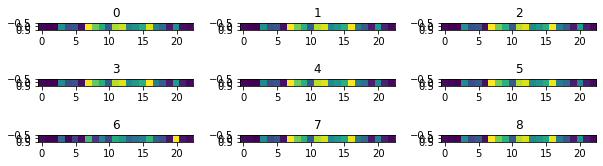

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.figure(figsize=(10,3))
plt.subplots_adjust(wspace =0.3, hspace =0.1)
for i in range(0,9):
    plt.subplot(330 + (i+1))
    plt.imshow(train_y_img[i].reshape(1,23))
    plt.title(i)

# 定義參數 for autoencoder

In [0]:
encoding_dim = 1
window_length = len(y_columns)
epochs = 300
x_train = train[y_columns]
x_test = test[y_columns]

# Simple feed-forward autoencoder

In [14]:
input_window = Input(shape=(window_length,))
encoded = Dense(encoding_dim, activation='linear')(input_window)
decoded = Dense(window_length, activation='linear')(encoded)

In [15]:
autoencoder = Model(input_window, decoded)
encoder = Model(input_window, encoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 23)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 24        
_________________________________________________________________
dense_2 (Dense)              (None, 23)                46        
Total params: 70
Trainable params: 70
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = autoencoder.fit(x_train,x_train,epochs=epochs,batch_size=1024,shuffle=True,validation_data=(x_test,x_test))
train_decoded = pd.DataFrame(autoencoder.predict(x_train),index=x_train.index,columns=x_train.columns)
test_decoded = pd.DataFrame(autoencoder.predict(x_test),index=x_test.index,columns=x_test.columns)




Train on 4521 samples, validate on 170 samples
Epoch 1/300





4521/4521 [==============================] - 0s 40us/step - loss: 0.0029 - val_loss: 0.0025
Epoch 2/300
4521/4521 [==============================] - 0s 3us/step - loss: 0.0025 - val_loss: 0.0021
Epoch 3/300
4521/4521 [==============================] - 0s 4us/step - loss: 0.0021 - val_loss: 0.0018
Epoch 4/300
4521/4521 [==============================] - 0s 3us/step - loss: 0.0018 - val_loss: 0.0015
Epoch 5/300
4521/4521 [==============================] - 0s 3us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 6/300
4521/4521 [==============================] - 0s 3us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 7/300
4521/4521 [==============================] - 0s 3us/step - loss: 0.0011 - val_loss: 9.1811e-04
Epoch 8/300
4521/4521 [==============================] - 0s 3us/step - loss: 9.7123e-04 - val_loss: 7.8234e-04
Epoch 9/300
4521/4521 [==============================] - 0s 3us/step - loss: 8.4790e-04 - val_loss: 6.7183e-

# 訓練過程

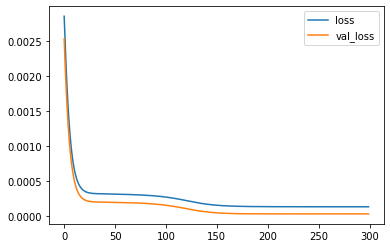

In [17]:
plt.plot(autoencoder.history.history['loss'],label='loss')
plt.plot(autoencoder.history.history['val_loss'],label='val_loss')
plt.legend()

# 還原成效評估

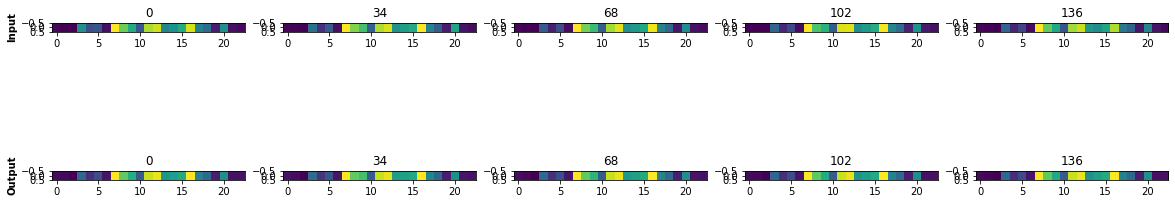

In [18]:
plot_examples(x_train,train_decoded)

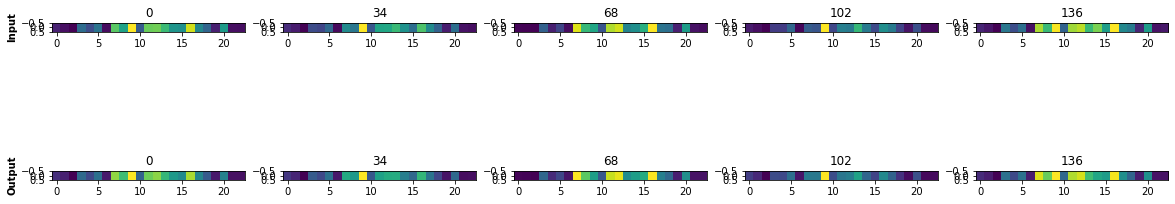

In [19]:
plot_examples(x_test,test_decoded)

# metric評估

In [20]:
metric(x_train,train_decoded)

,R2,RMSE,RMSE%
score,0.381451,0.011692,NaN


In [21]:
metric(x_test,test_decoded)

,R2,RMSE,RMSE%
score,0.193224,0.005962,NaN


# 精隨可視化

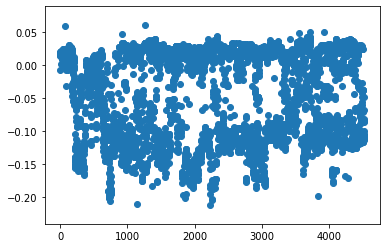

In [22]:
plt.scatter(x_train.index,encoder.predict(x_train))

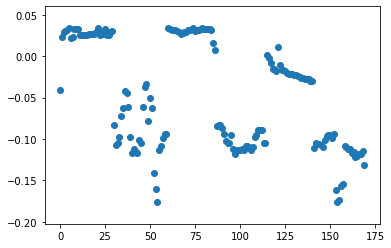

In [23]:
plt.scatter(x_test.index,encoder.predict(x_test))

# Deep autoencoder

In [0]:
input_window = Input(shape=(23,))
x0 = Dense(48, activation='linear')(input_window)
x1 = Dense(24, activation='linear')(x0)
x2 = Dense(12, activation='linear')(x1)
#===========================================
encoded = Dense(encoding_dim, activation='linear')(x2)
#===========================================
x2_ = Dense(12, activation='linear')(encoded)
x1_ = Dense(24, activation='linear')(x2_)
x0_ = Dense(48, activation='linear')(x1_)
decoded = Dense(23, activation='linear')(x0_)

In [0]:
autoencoder = Model(input_window, decoded)

In [0]:
encoder = Model(input_window, encoded)

In [0]:
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-4](encoded_input)
decoder_layer = autoencoder.layers[-3](decoder_layer)
decoder_layer = autoencoder.layers[-2](decoder_layer)
decoder_layer = autoencoder.layers[-1](decoder_layer)
decoder = Model(encoded_input, decoder_layer)

In [28]:
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 23)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 48)                1152      
_________________________________________________________________
dense_4 (Dense)              (None, 24)                1176      
_________________________________________________________________
dense_5 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 13        
_________________________________________________________________
dense_7 (Dense)              (None, 12)                24        
_________________________________________________________________
dense_8 (Dense)              (None, 24)                312 

In [29]:
history = autoencoder.fit(x_train, x_train,epochs = epochs,batch_size = 1024,validation_data = (x_test, x_test) )
train_decoded = pd.DataFrame(autoencoder.predict(x_train),index=x_train.index,columns=x_train.columns)
test_decoded = pd.DataFrame(autoencoder.predict(x_test),index=x_test.index,columns=x_test.columns)

Train on 4521 samples, validate on 170 samples
Epoch 1/300
4521/4521 [==============================] - 0s 97us/step - loss: 0.0026 - val_loss: 0.0014
Epoch 2/300
4521/4521 [==============================] - 0s 5us/step - loss: 0.0012 - val_loss: 6.0086e-04
Epoch 3/300
4521/4521 [==============================] - 0s 5us/step - loss: 6.2183e-04 - val_loss: 3.3328e-04
Epoch 4/300
4521/4521 [==============================] - 0s 6us/step - loss: 4.3565e-04 - val_loss: 2.5083e-04
Epoch 5/300
4521/4521 [==============================] - 0s 6us/step - loss: 3.7807e-04 - val_loss: 2.5942e-04
Epoch 6/300
4521/4521 [==============================] - 0s 5us/step - loss: 3.7289e-04 - val_loss: 2.5152e-04
Epoch 7/300
4521/4521 [==============================] - 0s 5us/step - loss: 3.6275e-04 - val_loss: 2.3813e-04
Epoch 8/300
4521/4521 [==============================] - 0s 6us/step - loss: 3.4313e-04 - val_loss: 2.1360e-04
Epoch 9/300
4521/4521 [==============================] - 0s 7us/step - loss:

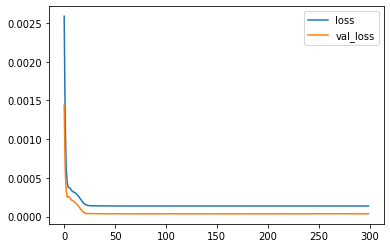

In [30]:
plt.plot(autoencoder.history.history['loss'],label='loss')
plt.plot(autoencoder.history.history['val_loss'],label='val_loss')
plt.legend()

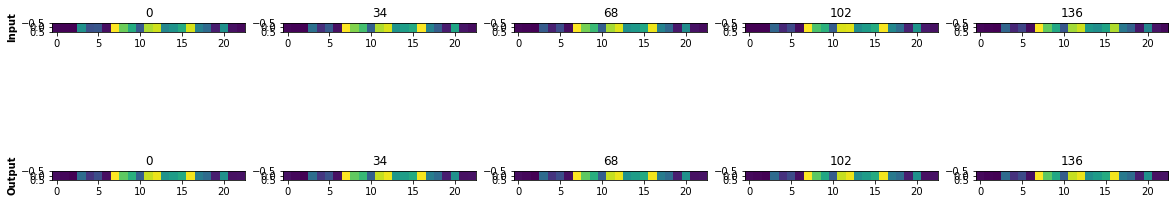

In [31]:
plot_examples(x_train,train_decoded)

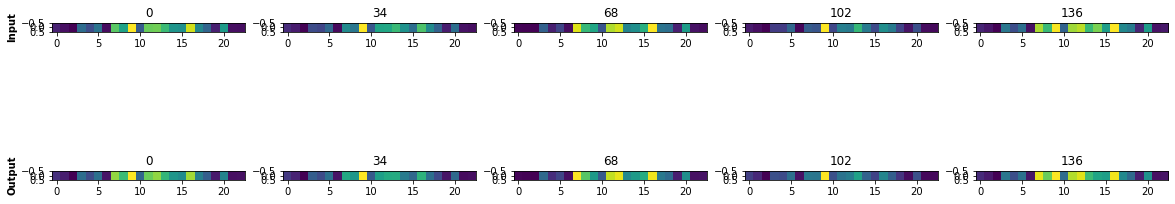

In [32]:
plot_examples(x_test,test_decoded)

In [33]:
metric(x_train,train_decoded)

,R2,RMSE,RMSE%
score,0.377858,0.011703,NaN


In [34]:
metric(x_test,test_decoded)

,R2,RMSE,RMSE%
score,0.283996,0.006054,NaN


# 精隨可視化

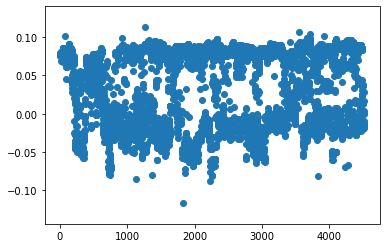

In [35]:
train['精隨'] = encoder.predict(x_train)
plt.scatter(x_train.index,train['精隨'])

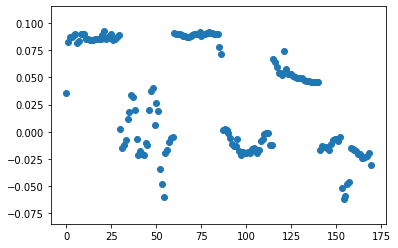

In [36]:
test['精隨'] = encoder.predict(x_test)
plt.scatter(x_test.index,test['精隨'])

# 精隨與原始資料相關性

In [37]:
train.corr().loc[['精隨'],features]

,T10,T50,T90,N+A
精隨,0.648722,0.68303,0.259523,-0.878447


In [38]:
test.corr().loc[['精隨'],features]

,T10,T50,T90,N+A
精隨,0.907379,0.881749,0.664851,-0.987677


# 精隨與ISOMAP特徵相關性

In [0]:
from sklearn.manifold import isomap
iso = isomap.Isomap(n_components=1)
train['iso_1'] = iso.fit_transform(train[['T10','N+A']])
test['iso_1'] = iso.transform(test[['T10','N+A']])

In [0]:
from sklearn.manifold import isomap
iso = isomap.Isomap(n_components=1)
train['iso_2'] = iso.fit_transform(train[['T50','N+A']])
test['iso_2'] = iso.transform(test[['T50','N+A']])

In [0]:
from sklearn.manifold import isomap
iso = isomap.Isomap(n_components=1)
train['iso_3'] = iso.fit_transform(train[['T90','N+A']])
test['iso_3'] = iso.transform(test[['T90','N+A']])

In [0]:
from sklearn.manifold import isomap
iso = isomap.Isomap(n_components=1)
train['iso'] = iso.fit_transform(train[['iso_1','iso_2','iso_3']])
test['iso'] = iso.transform(test[['iso_1','iso_2','iso_3']])

In [43]:
train.corr().loc[['精隨'],features+['iso_1','iso_2','iso_3','iso']]

,T10,T50,T90,N+A,iso_1,iso_2,iso_3,iso
精隨,0.648722,0.68303,0.259523,-0.878447,-0.939497,-0.911078,-0.740577,-0.924506


In [44]:
test.corr().loc[['精隨'],features+['iso_1','iso_2','iso_3','iso']]

,T10,T50,T90,N+A,iso_1,iso_2,iso_3,iso
精隨,0.907379,0.881749,0.664851,-0.987677,-0.993212,-0.988622,-0.95322,-0.990963


# modeling

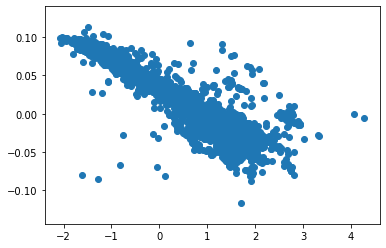

In [55]:
plt.scatter(train['iso_1'],train['精隨'])

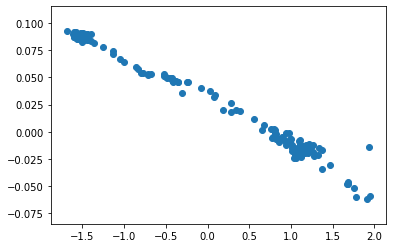

In [56]:
plt.scatter(test['iso_1'],test['精隨'])

In [57]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train[['iso_1']],train['精隨'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [58]:
train['y_pred'] = model.predict(train[['iso_1']])
metric(train['精隨'],train['y_pred'])

,R2,RMSE,RMSE%
score,0.882655,0.017083,0.543538


In [59]:
test['y_pred'] = model.predict(test[['iso_1']])
metric(test['精隨'],test['y_pred'])

,R2,RMSE,RMSE%
score,0.974451,0.007604,0.245347


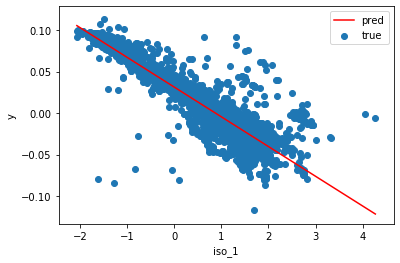

In [60]:
train = train.sort_values(by='iso_1')
plt.plot(train['iso_1'],train['y_pred'],color='red',label='pred')
plt.scatter(train['iso_1'],train['精隨'],label='true')
plt.xlabel('iso_1')
plt.ylabel('y')
plt.legend()
plt.show()

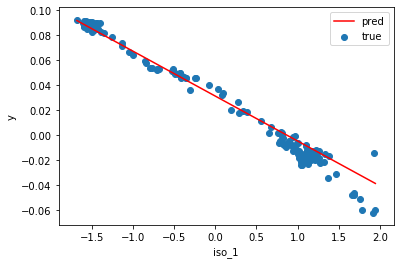

In [62]:
test = test.sort_values(by='iso_1')
plt.plot(test['iso_1'],test['y_pred'],color='red',label='pred')
plt.scatter(test['iso_1'],test['精隨'],label='true')
plt.xlabel('iso_1')
plt.ylabel('y')
plt.legend()
plt.show()

In [63]:
y_pred_all = pd.DataFrame(decoder.predict(test['精隨']),index=test.index,columns=y_columns)
y_pred_all.head(3)

,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
21,0.000735,0.000129,0.000355,0.036952,0.013537,0.021154,0.004357,0.108691,0.079898,0.054442,0.030677,0.098724,0.105050,0.048781,0.058793,0.067576,0.105772,0.043282,0.038304,0.009593,0.054127,0.005280,0.005665
72,0.001365,0.000552,0.000435,0.036979,0.014023,0.021881,0.004500,0.107671,0.079467,0.056357,0.030839,0.097859,0.104162,0.049543,0.058586,0.066830,0.104979,0.043353,0.038037,0.009579,0.053802,0.005318,0.005712
2,0.002232,0.001135,0.000544,0.037016,0.014692,0.022881,0.004697,0.106266,0.078874,0.058993,0.031061,0.096668,0.102940,0.050590,0.058302,0.065803,0.103889,0.043450,0.037669,0.009558,0.053355,0.005371,0.005776


# 看N+A準不準

In [83]:
na_col = [ col for col in y_columns if ('NP' not in col) and ('IP' not in col)]
print(na_col)
y_pred_all['N+A_pred'] = y_pred_all[na_col].sum(axis=1)*100
y_pred_all[['N+A_pred']].head()

['C5N', 'C6N', 'C6A', 'C7N', 'C7A', 'C8N', 'C8A', 'C9N', 'C9A', 'C10N', 'C10A']


,N+A_pred
21,31.109016
72,31.456011
2,31.933455
74,31.232744
71,31.476957


In [85]:
pd.DataFrame(transer_x.inverse_transform(test[features]),index=test.index,columns=features)[['N+A']].head()

,N+A
21,30.9710
72,31.3343
2,31.4280
74,31.2280
71,31.2680


In [86]:
test[y_columns] = test[y_columns]
test[y_columns].head(3)

,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
21,0.00067,0.00049,0.00006,0.03168,0.00748,0.02106,0.00345,0.11105,0.07770,0.06383,0.02943,0.10144,0.10842,0.04955,0.05475,0.06850,0.11148,0.04175,0.03760,0.00871,0.05722,0.004910,0.00332
72,0.00046,0.00025,0.00011,0.03597,0.01070,0.02198,0.00383,0.10550,0.07495,0.06169,0.02868,0.09621,0.10207,0.04749,0.05509,0.06991,0.11010,0.04213,0.04207,0.01114,0.06308,0.005743,0.00453
2,0.00098,0.00064,0.00020,0.03920,0.01447,0.02296,0.00396,0.10236,0.07348,0.06259,0.02797,0.09655,0.09986,0.04942,0.05453,0.06947,0.10996,0.04269,0.03997,0.01034,0.06107,0.005430,0.00456


In [87]:
t = pd.DataFrame()
for col in y_columns:
  t = t.append(metric(test[col]*100,y_pred_all[col]*100))
t.index = y_columns
t.loc['AVG'] = t.mean(axis=0)
t

,R2,RMSE,RMSE%
C5NP,-0.051875,0.876470,0.765699
C5IP,-0.586389,0.644528,0.927017
C5N,0.606804,0.085842,0.470366
C6NP,-0.610965,0.513505,0.148249
C6IP,0.764536,0.507209,0.213796
C6N,0.921670,0.463485,0.115497
C6A,-2.259457,0.308451,0.554791
C7NP,0.856228,0.833905,0.108923
C7IP,0.165146,1.009647,0.161165
C7N,0.954010,0.893703,0.081161
